In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.datasets import make_classification

In [2]:
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN']
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW'] 
feat_types = ['moe', 'mfp']
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']

In [5]:
nek_order = ['NEK2_binding (4.24%)','NEK9_binding (4.59%)','NEK3_binding (6.03%)','NEK2_inhibition (6.85%)','NEK5_binding (8.06%)','NEK9_inhibition (11.25%)' ]


# style='modeling_type',markers=rf_type_dict
model_types_dict = {'RF': 'p', 'GP_matern':'^' }
markers3 = {'RF': 'o', 'RF_BCW': '*', 'BRFC':'s', 'BRFC_BCW': 'p', 'GP_matern':'v'}
rf_type_dict ={'RF': '^', 'RF_GS': 's'} 

special_palette = sns.color_palette("cubehelix", n_colors=6)
# array(['raw_RF', 'raw_RF_BCW', 'raw_BRFC', 'raw_BRFC_BCW', 'UNDER_RF',
#        'ADASYN_RF'], dtype=object)

special_palette = {'raw_RF': '#8C5383', 'raw_RF_BCW': '#92374D', 
                   'raw_BRFC': '#9CD08F', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': '#A3CEF1'}

special_palette2 = {'raw_RF': 'tab:red', 'raw_RF_BCW': 'purple', 
                   'raw_BRFC': 'limegreen', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': 'yellow'}
special_palette3 = {'raw_RF': 'tab:red', 'raw_RF_BCW': 'purple', 
                   'raw_BRFC': 'limegreen', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': 'yellow', 
                   'raw_GP':'tab:red', 'UNDER_GP':'#42BFDD', 'ADASYN_GP':'yellow' }
strategy_order3 = list(special_palette3.keys())
special_palette4 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red' }
                   
this_palette = {'raw': 'tab:blue', 'UNDER': 'tab:orange', 'ADASYN': 'tab:red'}
marker_sizes = {'raw_RF': 200, 'raw_RF_BCW': 350, 
                   'raw_BRFC':200, 'raw_BRFC_BCW':200, 
                   'UNDER_RF': 200, 'ADASYN_RF':200, 
                   'raw_GP':200, 'UNDER_GP':200, 'ADASYN_GP':200} 

In [6]:
samp_markers = {'raw': 'o', 'UNDER': 'd', 'SMOTE': '>', 'ADASYN': '<'}
shapes = ['*', 'd', 'v', '.', 'o', '^'] 
palette = sns.color_palette("Set2")
nek_colors = {'NEK2_binding (4.24%)':palette[0], 'NEK2_inhibition (6.85%)': palette[1],
       'NEK3_binding (6.03%)': palette[2], 'NEK5_binding (8.06%)': palette[3],
       'NEK9_binding (4.59%)': palette[4], 'NEK9_inhibition (11.25%)' : palette[5]}


nek_markers = {'NEK2_binding (4.24%)':'*', 'NEK2_inhibition (6.85%)': 'd',
       'NEK3_binding (6.03%)': 'v', 'NEK5_binding (8.06%)': 'X',
       'NEK9_binding (4.59%)': 'o', 'NEK9_inhibition (11.25%)' : '^'}

In [7]:
# ratio_df = pd.read_excel('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/dataset_creation/NEK_condensed_sizes.xlsx')
# nek_ratios = {}
# raw_dfs = ratio_df[ratio_df['strategy']=='raw']
# for k, val in enumerate(raw_dfs['NEK']): 
#     nek_ratios[val] =list(raw_dfs['active%_test'])[k]
# for k, val in nek_ratios.items(): 
#     this_val = f"{val:.2f}"
#     new_val = k+' ('+this_val+'%)'
#     nek_ratios[k] = new_val
nek_ratios = {'NEK2_binding':'NEK2_binding (4.24%)', 'NEK9_binding':'NEK9_binding (4.59%)' ,'NEK3_binding': 'NEK3_binding (6.03%)',
             'NEK2_inhibition':'NEK2_inhibition (6.85%)','NEK5_binding':'NEK5_binding (8.06%)','NEK9_inhibition':'NEK9_inhibition (11.25%)' } 
# redo bc of nek2 inhib duplicates 

# pairing down models/datasetes

In [8]:
df = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.csv')
df = df[(df['set'] !='literature') & (df['modeling_type']!='RF_GS')]

df = df[(df['strategy'] != 'SMOTE') & (df['set'] !='literature')]
rf= df[df['modeling_type'] != 'GP']
rf= rf[rf['modeling_type'] != 'GP_matern']

rf['modeling_type'].unique()
rf_raw = rf[(rf['strategy'] == 'raw') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 
total_rf['strategy'] =total_rf['strategy'].astype(str) +'_'+ total_rf['RF_type']

total_rf['modeling_type'] ='RF'

gp= df[df['modeling_type'] == 'GP_matern']
gp['strategy'] = gp['strategy'].astype(str)+'_GP'

full_df = pd.concat([gp, total_rf]) 
full_df['1-specificity'] = 1-full_df['specificity']

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_92243/2743923972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gp['strategy'] = gp['strategy'].astype(str)+'_GP'


# all results moe vs mfp

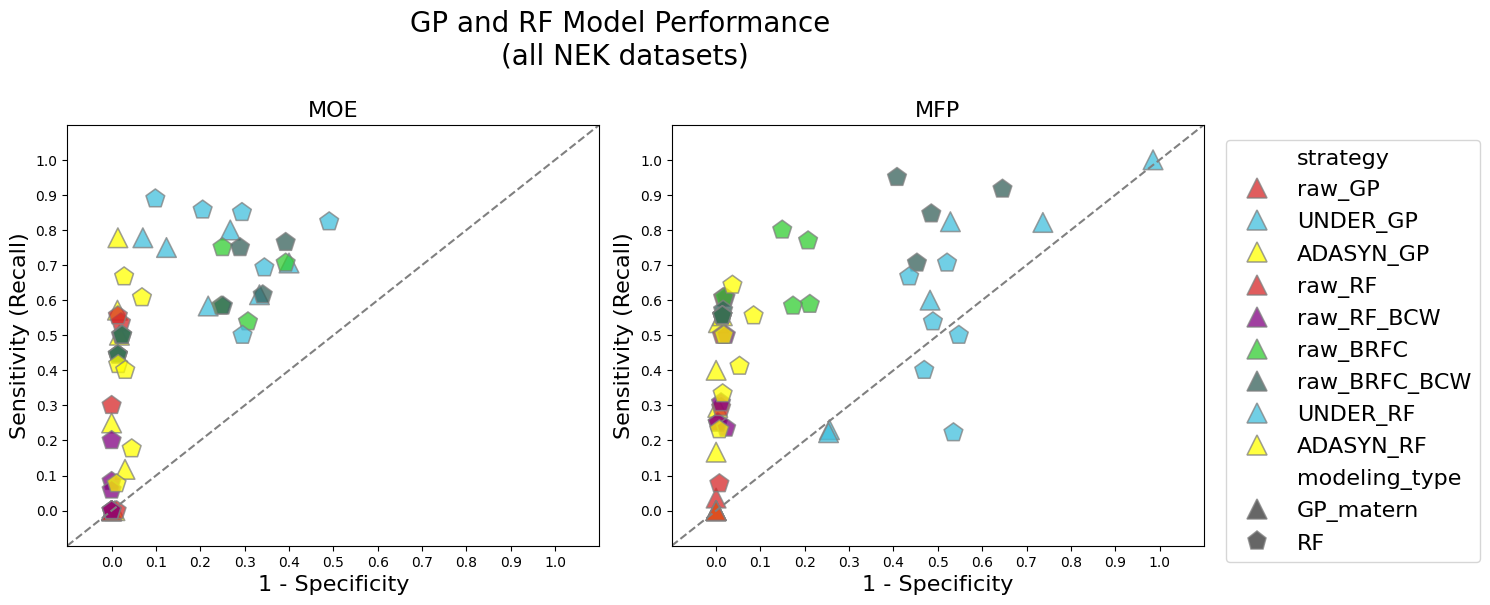

In [9]:

fig, axs = plt.subplots(1,2, figsize=(15,6))

moe_df =full_df[full_df['feat_type'] == 'moe']
mfp_df = full_df[full_df['feat_type'] == 'mfp']

sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
               alpha=0.75, palette=special_palette3,s=200, edgecolor='gray', ax=axs[0])
sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
               alpha=0.75, palette=special_palette3,s=200,legend=True, ax=axs[1],edgecolor='gray')

plt.suptitle(f'GP and RF Model Performance \n(all NEK datasets)', fontsize=20, x=0.42, y =1.0005)

plt.legend(bbox_to_anchor = [.2, 0.9])
for i in range(len(axs)): 
    
    axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
    axs[i].get_legend().remove()
    axs[i].set_xlabel('1 - Specificity', fontsize=16)
    axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks(np.arange(0, 1.1, 0.1))
    axs[i].set_yticks(np.arange(0, 1.1, 0.1))
    if (i==0): 
        this_title='MOE'
    else: 
        this_title='MFP' 
    

    axs[i].set_title(f'{this_title}', fontsize=16)


axs[1].legend(ncols=1, bbox_to_anchor=(1.02, 0.99),fontsize=16)
plt.tight_layout();
# plt.savefig(f'{figure_path}all_NEK/RF_and_GP.png', bbox_inches='tight')

plt.show();


In [15]:
full_df['NEK'].value_counts()
full_df['regular NEK'] = full_df['NEK'].str.split(' ').str[0]
full_df['regular NEK'].value_counts()
full_df['dataset type'] = ['binding' if nek in ['NEK2_binding','NEK3_binding','NEK5_binding','NEK9_binding'] else 'inhibition' for nek in full_df['regular NEK']]
full_df['dataset type'].value_counts()

dataset type
binding       72
inhibition    36
Name: count, dtype: int64

# Binding and Inhibition separate (and separated by moe mfp)

In [16]:
bind_df = full_df[full_df['dataset type'] == 'binding'] 
inhib_df =full_df[full_df['dataset type'] == 'inhibition'] 

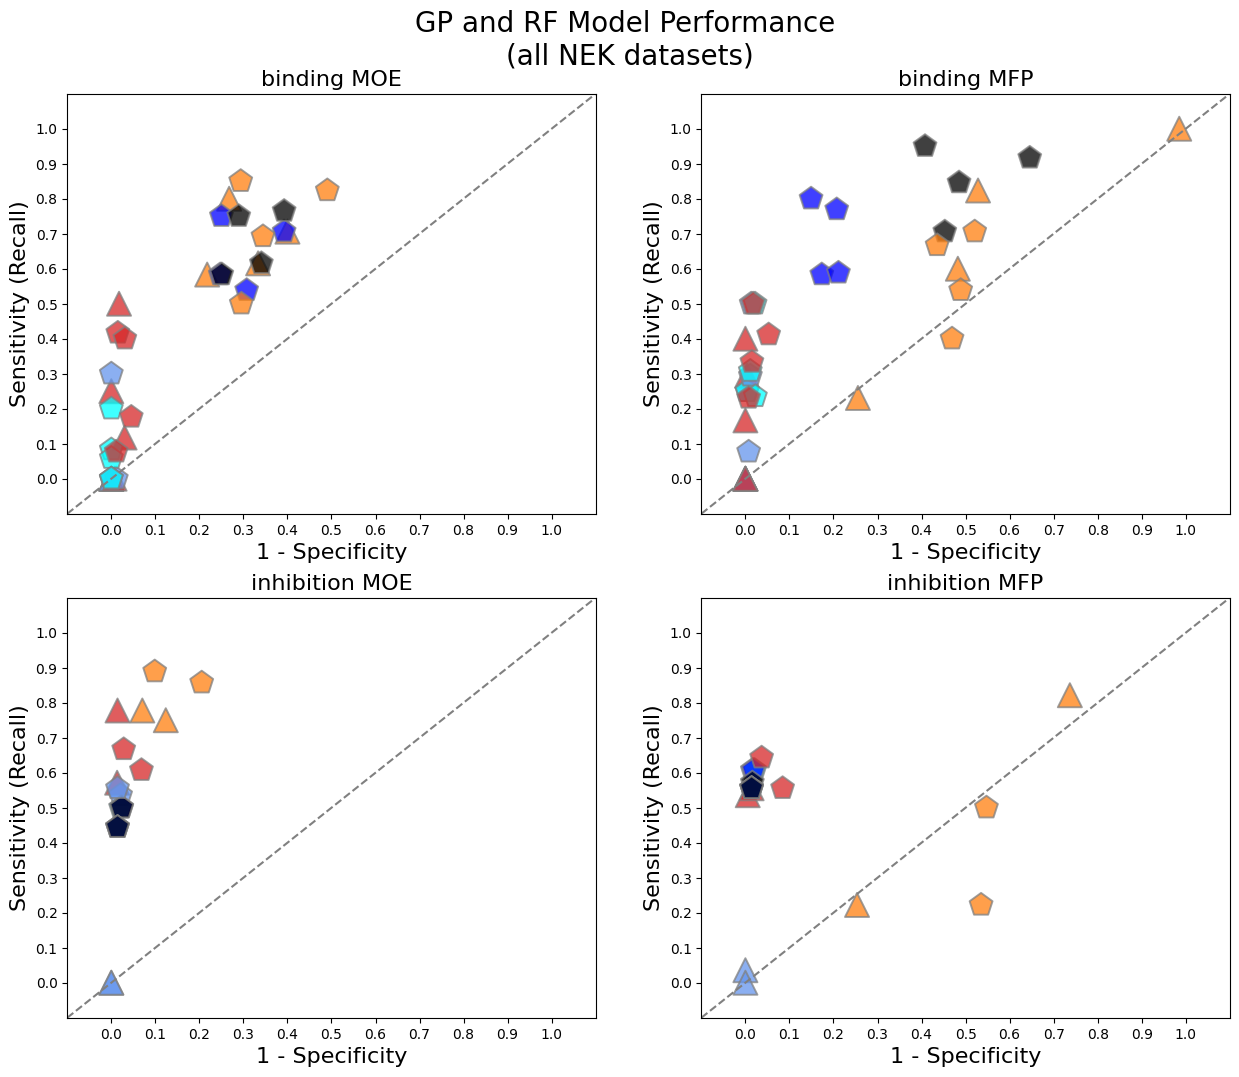

In [72]:
figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/best_models/sensitivity_1_specificity/all_NEK/'
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind_df, inhib_df])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    sizes=moe_df['strategy'].map(marker_sizes)
    sizes2=mfp_df['strategy'].map(marker_sizes)
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75, palette=special_palette4,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75, palette=special_palette4,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    # plt.legend(bbox_to_anchor = [.2, 0.9]) 
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    
    axs[i, 0].set_title(f'{moe_df["dataset type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["dataset type"].iloc[0]} MFP', fontsize=16)

model_types_dict = {'RF': 'p', 'GP_matern':'^' }
special_palette4 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red' }
# raw_GP = mlines.Line2D([],[], color='cornflowerblue', marker='^',markersize=15, label='raw_GP')
# raw_RF = mlines.Line2D([], [], color='cornflowerblue', marker='p',markersize=15, label='raw_RF')
# raw_RF_BCW = mlines.Line2D([], [], color='cyan', marker='p',markersize=15, label='raw_RF_BCW')
# raw_BRFC = mlines.Line2D([], [], color='blue', marker='p',markersize=15, label='bootstrap_undersample')
# raw_BRFC_BCW = mlines.Line2D([], [], color='black', marker='p',markersize=15, label='bootstrap_undersample_BCW')
# UNDER_RF = mlines.Line2D([], [], color='tab:orange', marker='p',markersize=15, label='UNDER_RF')
# ADASYN_RF= mlines.Line2D([], [], color='tab:red', marker='p',markersize=15, label='ADASYN_RF')
# UNDER_GP = mlines.Line2D([], [], color='tab:orange', marker='^',markersize=15, label='UNDER_GP')
# ADASYN_GP= mlines.Line2D([], [], color='tab:red', marker='^',markersize=15, label='ADASYN_GP')

raw_GP = Line2D([0], [0], color='cornflowerblue', marker='^', markersize=15, linestyle='None', markerfacecolor='cornflowerblue', markeredgewidth=0, label='raw_GP')
raw_RF = Line2D([0], [0], color='cornflowerblue', marker='p', markersize=15, linestyle='None', markerfacecolor='cornflowerblue', markeredgewidth=0, label='raw_RF')
raw_RF_BCW = Line2D([0], [0], color='cyan', marker='p', markersize=15, linestyle='None', markerfacecolor='cyan', markeredgewidth=0, label='raw_RF_BCW')
raw_BRFC = Line2D([0], [0], color='blue', marker='p', markersize=15, linestyle='None', markerfacecolor='blue', markeredgewidth=0, label='bootstrap_undersample')
raw_BRFC_BCW = Line2D([0], [0], color='black', marker='p', markersize=15, linestyle='None', markerfacecolor='black', markeredgewidth=0, label='bootstrap_undersample_BCW')
UNDER_RF = Line2D([0], [0], color='tab:orange', marker='p', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER_RF')
ADASYN_RF = Line2D([0], [0], color='tab:red', marker='p', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN_RF')
UNDER_GP = Line2D([0], [0], color='tab:orange', marker='^', markersize=15, linestyle='None', markerfacecolor='tab:orange', markeredgewidth=0, label='UNDER_GP')
ADASYN_GP = Line2D([0], [0], color='tab:red', marker='^', markersize=15, linestyle='None', markerfacecolor='tab:red', markeredgewidth=0, label='ADASYN_GP')



# axs[1,1].legend(handles=[raw_GP,raw_RF,raw_RF_BCW,ADASYN_GP,ADASYN_RF, UNDER_GP,UNDER_RF,raw_BRFC, raw_BRFC_BCW ], ncols=2, bbox_to_anchor=(.3, -.1) )


# axs[1,1].legend(ncols=1, bbox_to_anchor=(1.02, .99),fontsize=16)
plt.suptitle(f'GP and RF Model Performance \n(all NEK datasets)', fontsize=20, x=0.5, y=.950)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.savefig(f'{figure_path}binding_inhib_RF_GP.png', bbox_inches='tight')

plt.show();


In [20]:
# figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/best_models/sensitivity_1_specificity/all_NEK/'
# fig, axs = plt.subplots(1,2, figsize=(15,6))

# moe_df =selected[selected['feat_type'] == 'moe']
# mfp_df =selected[selected['feat_type'] == 'mfp']

# sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
#                alpha=0.5, palette=special_palette4,s=300, edgecolor='gray', ax=axs[0])
# sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
#                alpha=0.5, palette=special_palette4,s=300,legend=True, ax=axs[1],edgecolor='gray')
# for i in range(2):  
#     axs[i].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
#     axs[i].set_xlabel('1 - Specificity', fontsize=16)
#     axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
#     axs[i].set_xlim(-0.1, 1.1)
#     axs[i].set_ylim(-0.1, 1.1)
#     axs[i].set_xticks(np.arange(0, 1.1, 0.1))
#     axs[i].set_yticks(np.arange(0, 1.1, 0.1))
#     # axs[i].legend_.remove()
#     if i == 0: 
#         feat = 'MOE'
#     else: 
#         feat = 'MFP' 
#     axs[i].set_title(feat) 
# plt.suptitle('Inhibition Models (hidden points)', fontsize=20)
# # plt.savefig(f'{figure_path}inhib_hidden.png', bbox_inches='tight')
# plt.show();


# individual neks 

In [19]:
df = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.csv')
figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/best_models/sensitivity_1_specificity/'
gp= df[(df['set'] == 'original') & (df['modeling_type'] == 'GP_matern')]
gp = gp[gp['strategy'] != 'SMOTE']
rf = df[(df['set'] == 'original') & (df['modeling_type'] == 'RF')]
rf_raw = rf[(rf['strategy'] == 'raw') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
rf_filtered['modeling_type'] = rf['RF_type']
rf_gp = pd.concat([rf_filtered, gp])
rf_gp['1-specificity'] = 1-rf_gp['specificity']

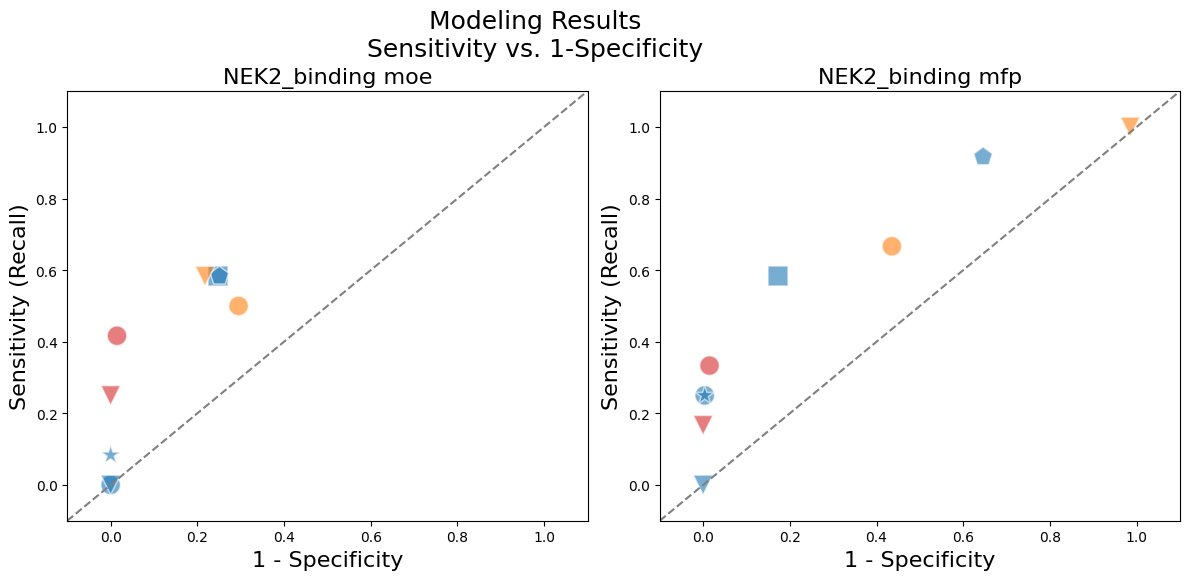

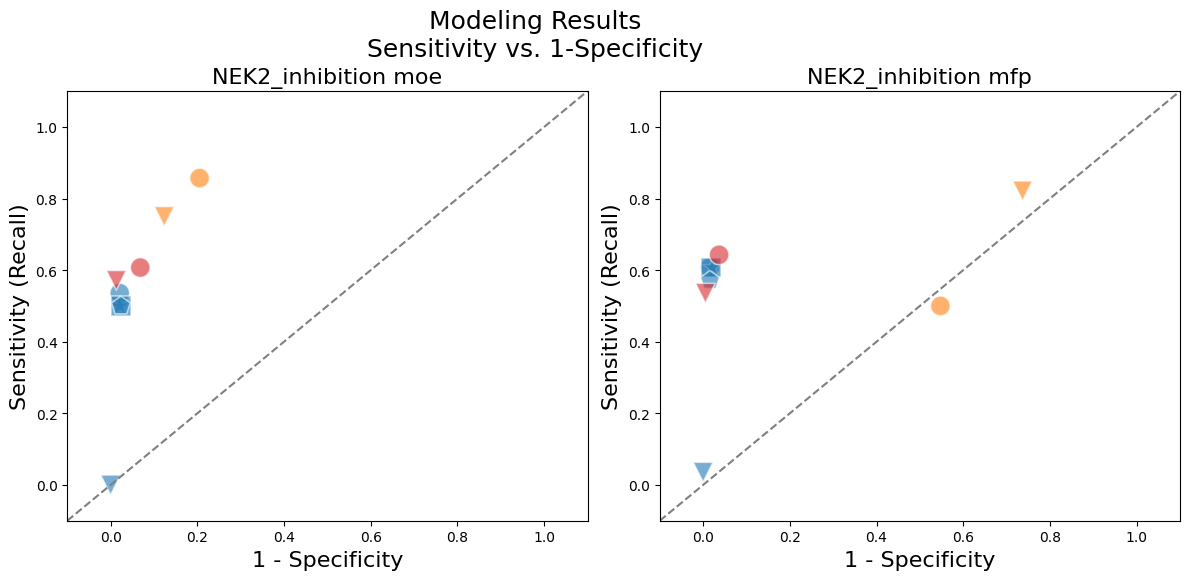

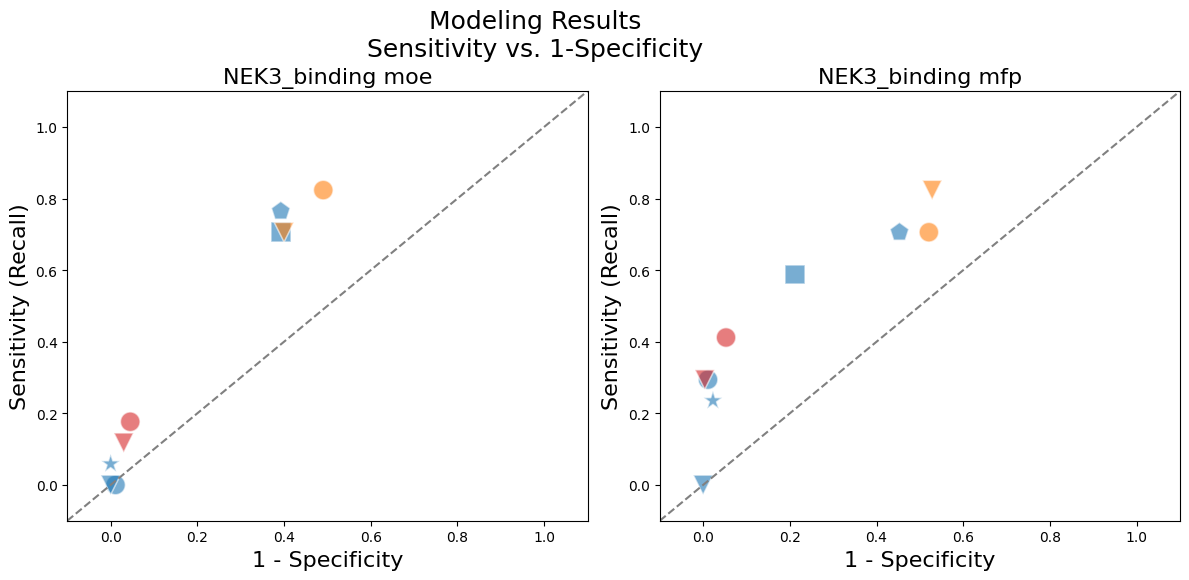

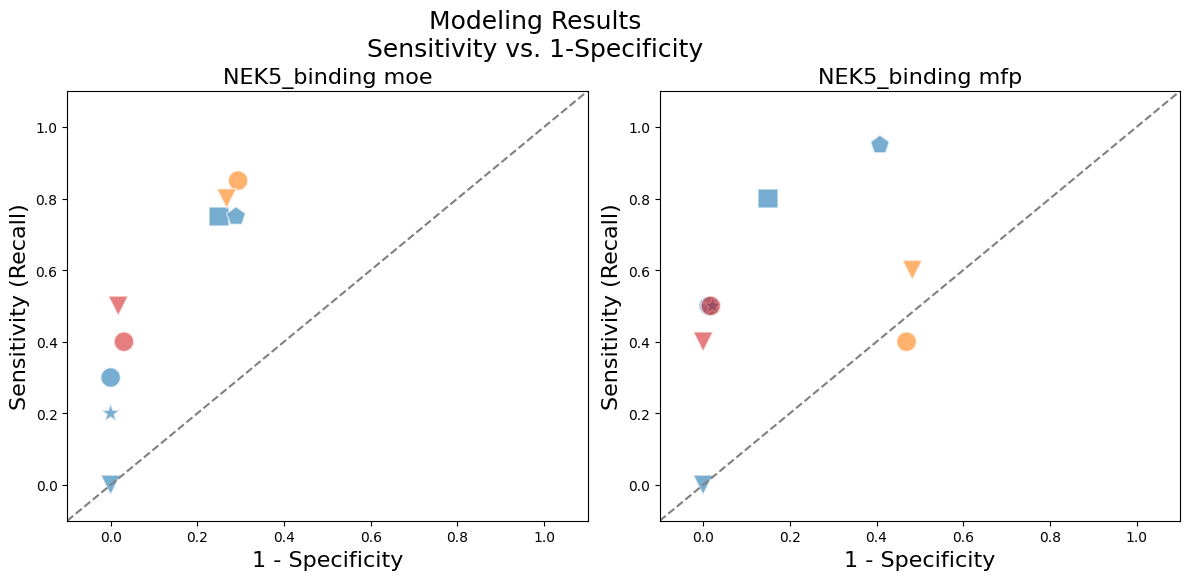

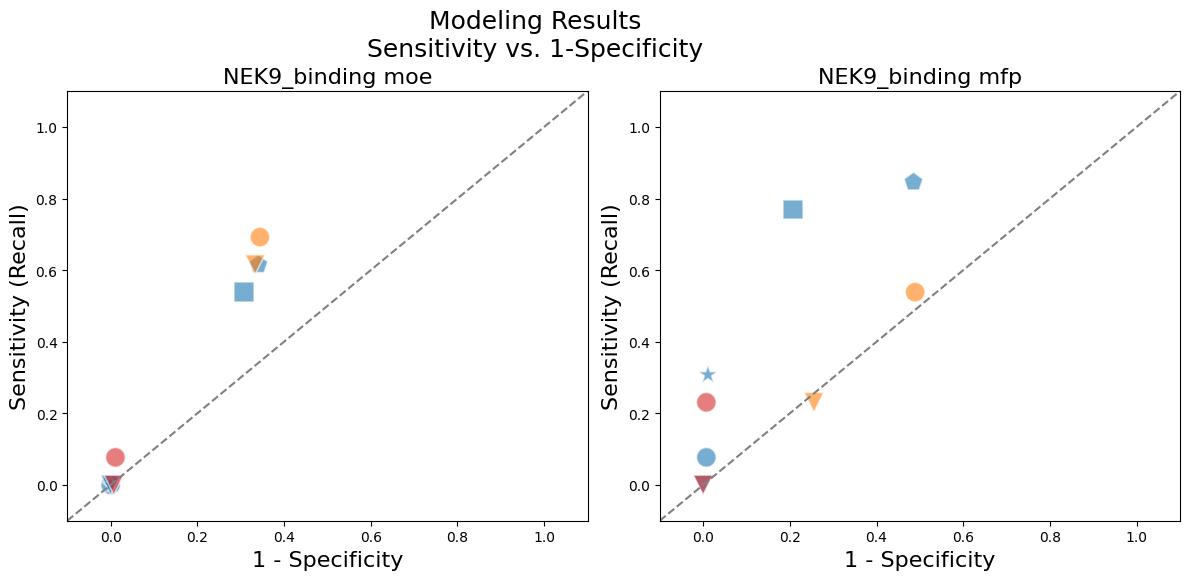

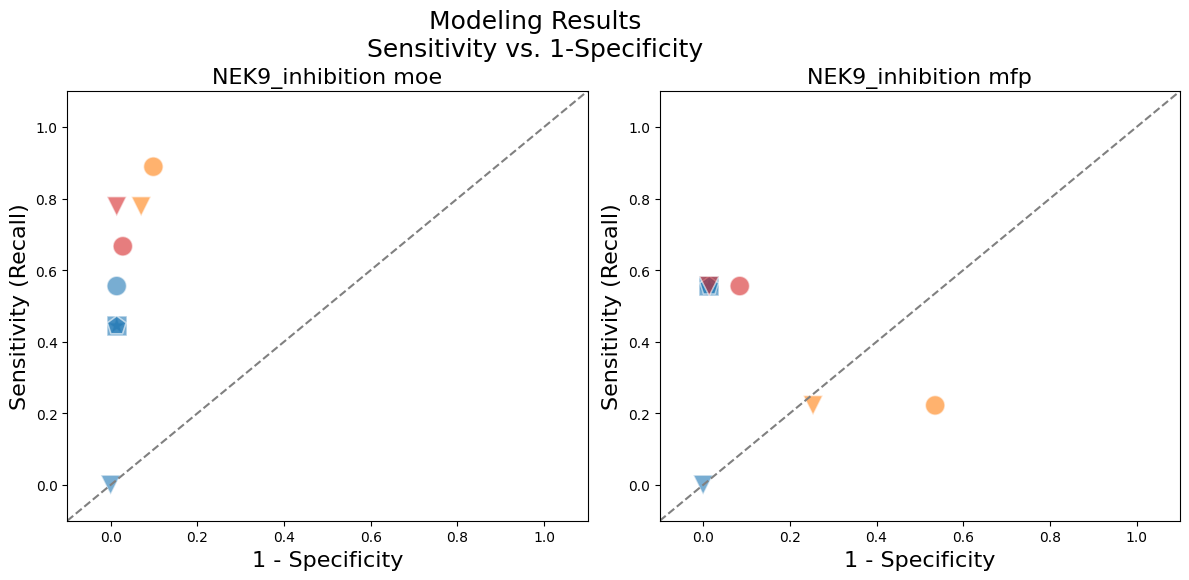

In [21]:
this_palette = {'raw': 'tab:blue', 'UNDER': 'tab:orange', 'ADASYN': 'tab:red'}
markers3 = {'RF': 'o', 'RF_BCW': '*', 'BRFC':'s', 'BRFC_BCW': 'p', 'GP_matern':'v'}
# full_df['strategy2']  = full_df['strategy'] 
# full_df['strategy'] = full_df['strategy2'].str.split('_').str[0]
figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/best_models/sensitivity_1_specificity/'
hue_order = ['raw', 'UNDER', 'ADASYN']

for nek in rf_gp['NEK'].unique():
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    moe_df = rf_gp[(rf_gp['NEK'] == nek) & (rf_gp['feat_type'] == 'moe')]
    
    mfp_df = rf_gp[(rf_gp['NEK'] == nek) & (rf_gp['feat_type'] == 'mfp')]
 

    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=markers3, s=200, alpha=0.6, ax=axs[0], palette=this_palette,hue_order=hue_order)
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy', style='modeling_type',
                    markers=markers3, s=200, alpha=0.6, ax=axs[1], palette=this_palette,hue_order=hue_order)
    plt.suptitle('Modeling Results\nSensitivity vs. 1-Specificity', fontsize=18, x=0.45, y =.96)
    for i, ax in enumerate(axs): 
        axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
        axs[i].set_xlim(-0.1, 1.1)
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_xlabel('1 - Specificity', fontsize=16)
        axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
        
        axs[i].get_legend().remove()
        
    axs[0].set_title(f'{nek} moe', fontsize=16)
    axs[1].set_title(f'{nek} mfp', fontsize=16)

    # axs[1].legend(ncols=1, bbox_to_anchor=(1.45, 0.75))
    plt.tight_layout()
    
    plt.savefig(f'{figure_path}GPRF_{nek}_moemfp.png', bbox_inches='tight')

    plt.show();

In [22]:

inhib_df 
bind_df
bind_df['strategy2'] = bind_df['strategy'].str.split('_').str[0]
bind_df['strategy2'] = bind_df['strategy'].str.split('_').str[0]
inhib_df 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_92243/2948389488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bind_df['strategy2'] = bind_df['strategy'].str.split('_').str[0]
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_92243/2948389488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bind_df['strategy2'] = bind_df['strategy'].str.split('_').str[0]


,model,NEK,set,modeling_type,feat_type,strategy,cm,recall,accuracy,precision,specificity,f1,MCC,Balanced Accuracy,ROC-AUC,RF_type,1-specificity,regular NEK,dataset type
112,NEK2_inhibition_moe_scaled_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,moe,raw_GP,"[380, 0, 28, 0]",0.000000,0.931373,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,NaN,0.000000,NEK2_inhibition,inhibition
113,NEK2_inhibition_moe_UNDER_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,moe,UNDER_GP,"[333, 47, 7, 21]",0.750000,0.867647,0.308824,0.876316,0.437500,0.424884,0.813158,0.813158,NaN,0.123684,NEK2_inhibition,inhibition
115,NEK2_inhibition_moe_ADASYN_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,moe,ADASYN_GP,"[375, 5, 12, 16]",0.571429,0.958333,0.761905,0.986842,0.653061,0.638779,0.779135,0.779135,NaN,0.013158,NEK2_inhibition,inhibition
116,NEK2_inhibition_mfp_scaled_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,mfp,raw_GP,"[380, 0, 27, 1]",0.035714,0.933824,1.000000,1.000000,0.068966,0.182606,0.517857,0.517857,NaN,0.000000,NEK2_inhibition,inhibition
117,NEK2_inhibition_mfp_UNDER_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,mfp,UNDER_GP,"[100, 280, 5, 23]",0.821429,0.301471,0.075908,0.263158,0.138973,0.048917,0.542293,0.542293,NaN,0.736842,NEK2_inhibition,inhibition
119,NEK2_inhibition_mfp_ADASYN_GP_Dirichlet_matern,NEK2_inhibition,original,GP_matern,mfp,ADASYN_GP,"[378, 2, 13, 15]",0.535714,0.963235,0.882353,0.994737,0.666667,0.671125,0.765226,0.765226,NaN,0.005263,NEK2_inhibition,inhibition
144,NEK9_inhibition_moe_scaled_GP_Dirichlet_matern,NEK9_inhibition,original,GP_matern,moe,raw_GP,"[71, 0, 9, 0]",0.000000,0.887500,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,NaN,0.000000,NEK9_inhibition,inhibition
145,NEK9_inhibition_moe_UNDER_GP_Dirichlet_matern,NEK9_inhibition,original,GP_matern,moe,UNDER_GP,"[66, 5, 2, 7]",0.777778,0.912500,0.583333,0.929577,0.666667,0.625955,0.853678,0.853678,NaN,0.070423,NEK9_inhibition,inhibition
147,NEK9_inhibition_moe_ADASYN_GP_Dirichlet_matern,NEK9_inhibition,original,GP_matern,moe,ADASYN_GP,"[70, 1, 2, 7]",0.777778,0.962500,0.875000,0.985915,0.823529,0.804374,0.881847,0.881847,NaN,0.014085,NEK9_inhibition,inhibition
148,NEK9_inhibition_mfp_scaled_GP_Dirichlet_matern,NEK9_inhibition,original,GP_matern,mfp,raw_GP,"[71, 0, 9, 0]",0.000000,0.887500,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,NaN,0.000000,NEK9_inhibition,inhibition


In [23]:
print("binding")
for feat in bind_df['feat_type'].unique(): 
    feat_df = bind_df[bind_df['feat_type'] == feat] 
    print(feat)
    avg_bind = feat_df.groupby('strategy')[['recall',  '1-specificity','precision', 'accuracy', 'ROC-AUC', 'specificity']].mean()
    display(avg_bind)

binding
moe


,recall,1-specificity,precision,accuracy,ROC-AUC,specificity
strategy,,,,,,
ADASYN_GP,0.216912,0.013785,0.478571,0.944296,0.601563,0.986215
ADASYN_RF,0.267515,0.025464,0.384722,0.934829,0.621026,0.974536
UNDER_GP,0.676150,0.304647,0.124295,0.695612,0.685751,0.695353
UNDER_RF,0.716459,0.356018,0.114401,0.649867,0.680221,0.643982
raw_BRFC,0.644419,0.299273,0.121038,0.698643,0.672573,0.700727
raw_BRFC_BCW,0.678356,0.318397,0.117407,0.682506,0.679979,0.681603
raw_GP,0.000000,0.000000,0.000000,0.942683,0.500000,1.000000
raw_RF,0.075000,0.002830,0.250000,0.946072,0.536085,0.997170
raw_RF_BCW,0.085539,0.000000,0.750000,0.948485,0.542770,1.000000


mfp


,recall,1-specificity,precision,accuracy,ROC-AUC,specificity
strategy,,,,,,
ADASYN_GP,0.215196,0.000943,0.708333,0.956060,0.607126,0.999057
ADASYN_RF,0.368967,0.023135,0.536905,0.943409,0.672916,0.976865
UNDER_GP,0.663575,0.562888,0.068487,0.448622,0.550343,0.437112
UNDER_RF,0.577753,0.478592,0.065854,0.523585,0.549581,0.521408
raw_BRFC,0.685200,0.185321,0.188165,0.807786,0.749940,0.814679
raw_BRFC_BCW,0.854676,0.497917,0.099289,0.521458,0.678380,0.502083
raw_GP,0.000000,0.000000,0.000000,0.942683,0.500000,1.000000
raw_RF,0.280260,0.008894,0.619391,0.952396,0.635683,0.991106
raw_RF_BCW,0.323247,0.014843,0.597024,0.948600,0.654202,0.985157


In [24]:
print("inhibition")
for feat in inhib_df['feat_type'].unique(): 
    feat_df = inhib_df[inhib_df['feat_type'] == feat] 
    print(feat)
    avg_inhib = feat_df.groupby('strategy')[['recall',  '1-specificity','precision', 'accuracy', 'ROC-AUC', 'specificity']].mean()
    display(avg_inhib)

inhibition
moe


,recall,1-specificity,precision,accuracy,ROC-AUC,specificity
strategy,,,,,,
ADASYN_GP,0.674603,0.013621,0.818452,0.960417,0.830491,0.986379
ADASYN_RF,0.636905,0.048295,0.572674,0.923407,0.794305,0.951705
UNDER_GP,0.763889,0.097053,0.446078,0.890074,0.833418,0.902947
UNDER_RF,0.873016,0.151927,0.384314,0.849510,0.860544,0.848073
raw_BRFC,0.472222,0.018884,0.704348,0.934314,0.726669,0.981116
raw_BRFC_BCW,0.472222,0.018884,0.704348,0.934314,0.726669,0.981116
raw_GP,0.000000,0.000000,0.000000,0.909436,0.500000,1.000000
raw_RF,0.545635,0.017569,0.742754,0.943015,0.764033,0.982431
raw_RF_BCW,0.472222,0.017569,0.718182,0.935539,0.727327,0.982431


mfp


,recall,1-specificity,precision,accuracy,ROC-AUC,specificity
strategy,,,,,,
ADASYN_GP,0.545635,0.009674,0.857843,0.950368,0.767981,0.990326
ADASYN_RF,0.599206,0.060675,0.508523,0.908088,0.769266,0.939325
UNDER_GP,0.521825,0.495182,0.087954,0.494485,0.513322,0.504818
UNDER_RF,0.361111,0.541290,0.056532,0.446691,0.409911,0.458710
raw_BRFC,0.581349,0.016253,0.770833,0.946691,0.782548,0.983747
raw_BRFC_BCW,0.563492,0.014937,0.780303,0.946691,0.774278,0.985063
raw_GP,0.017857,0.000000,0.500000,0.910662,0.508929,1.000000
raw_RF,0.581349,0.014937,0.786232,0.947917,0.783206,0.985063
raw_RF_BCW,0.581349,0.017569,0.756667,0.945466,0.781890,0.982431


In [ ]:
dfnek2 = df[df['NEK'] == 'NEK2_binding']
dfnek2
dflong = pd.melt(dfnek2, id_vars=['model'], 
                 value_vars=['recall', 'specificity', 'accuracy', 'precision', 
                             'ROC-AUC', 'MCC', 'Balanced Accuracy', 'f1'], 
                 var_name='Metric', value_name='Metric_value')

# Create a specific color mapping for the metrics
color_mapping = {
    'recall': '#FF9999',         # Light Red
    'specificity': '#FFCC99',    # Light Orange
    'accuracy': '#FFFF99',       # Light Yellow
    'precision': '#CCFF99',      # Light Green
    'ROC-AUC': '#99FF99',        # Light Light Green
    'MCC': '#99CCFF',            # Light Cyan
    'Balanced Accuracy': '#9999FF', # Light Blue
    'f1': '#CC99FF'              # Light Purple
}
display(dfnek2)
# Use a bar plot with color mapping
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=dflong, x='model', y='Metric_value', hue='Metric', palette=color_mapping)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Metric Score', fontsize=20)
plt.title('NEK2 Binding Metrics', fontsize=22)
plt.xticks(rotation=90)  
ax.legend(loc='upper left', bbox_to_anchor=(1, .6))

plt.tight_layout()

plt.show()

NEK2_binding


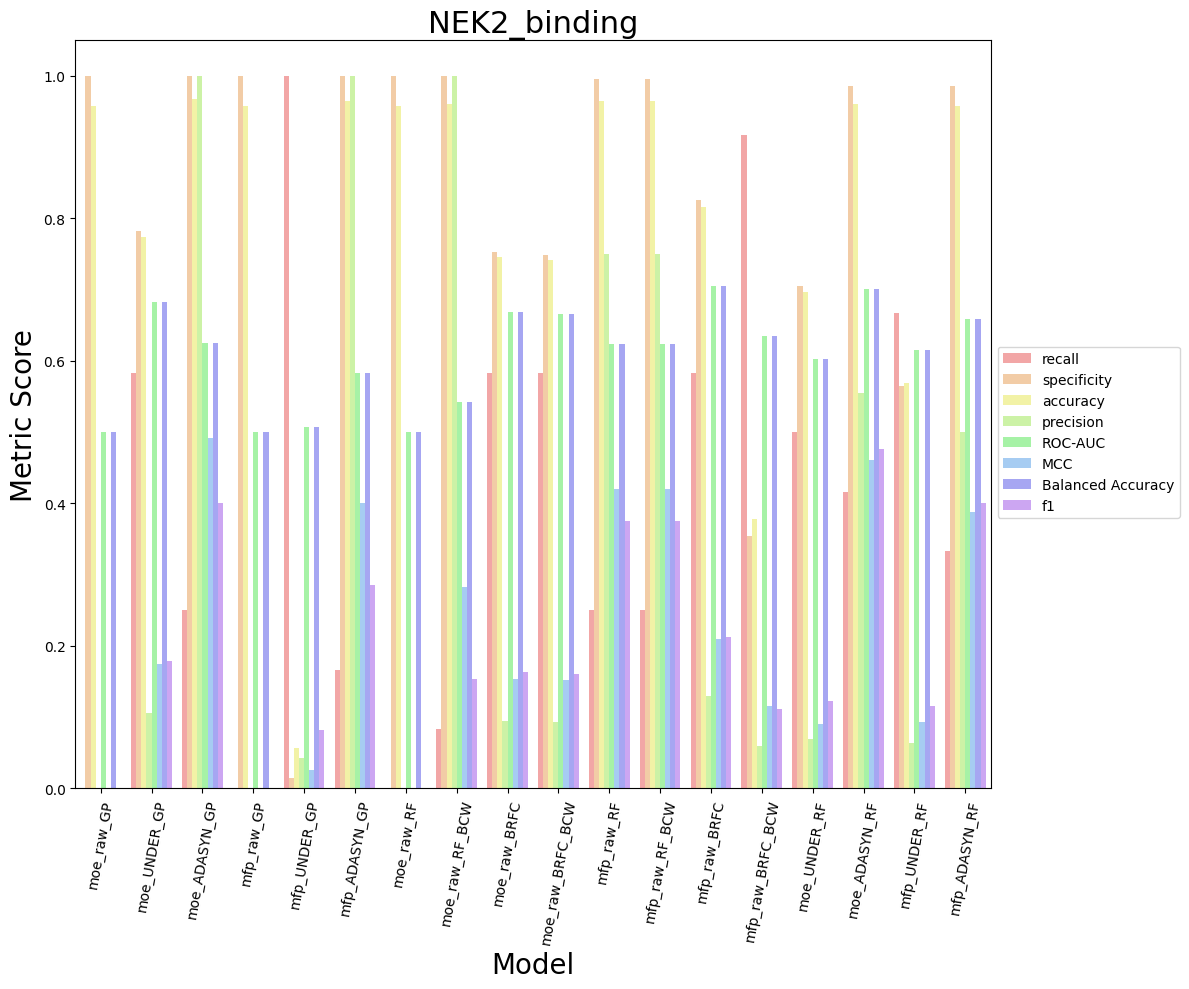

NEK3_binding


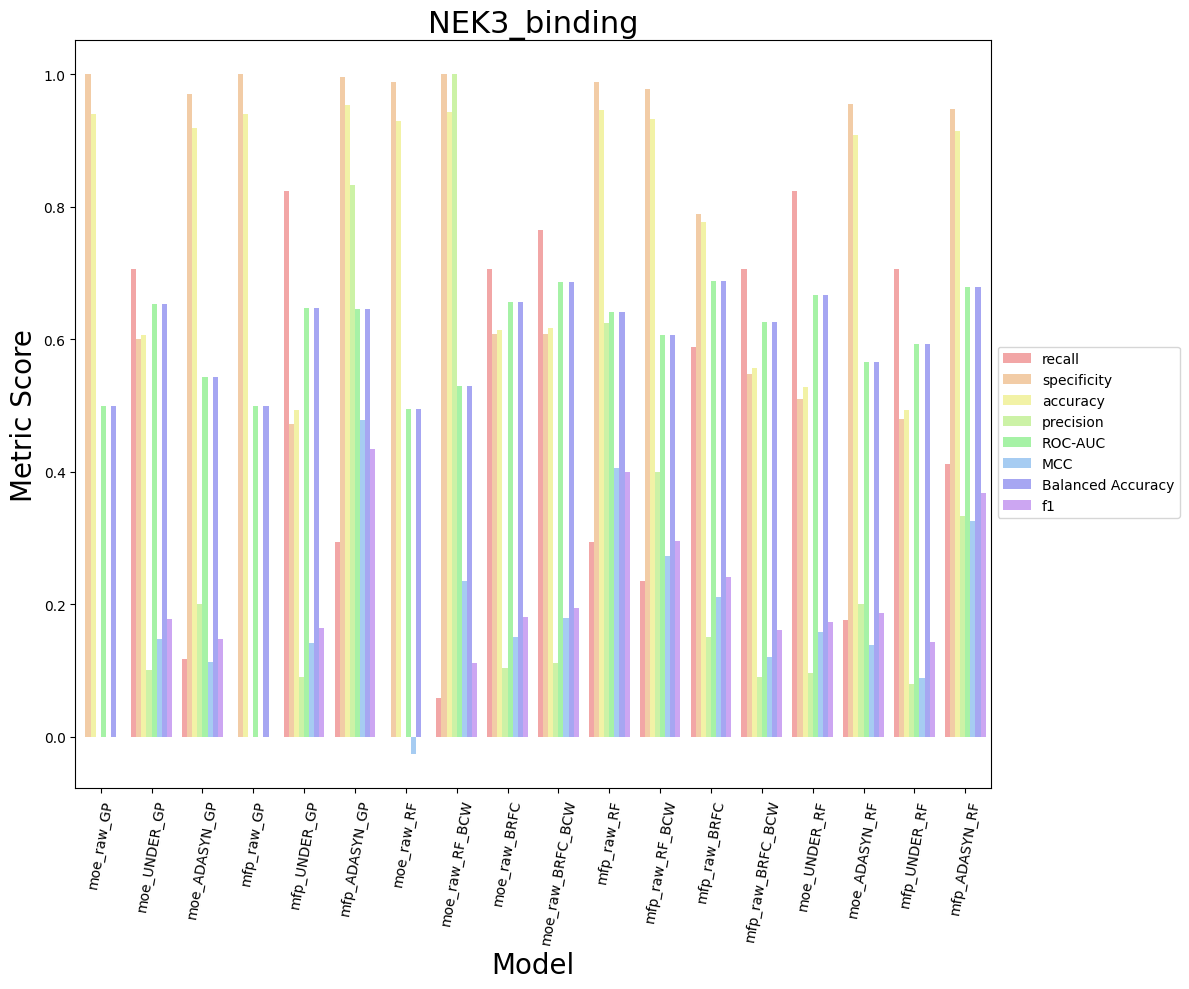

NEK5_binding


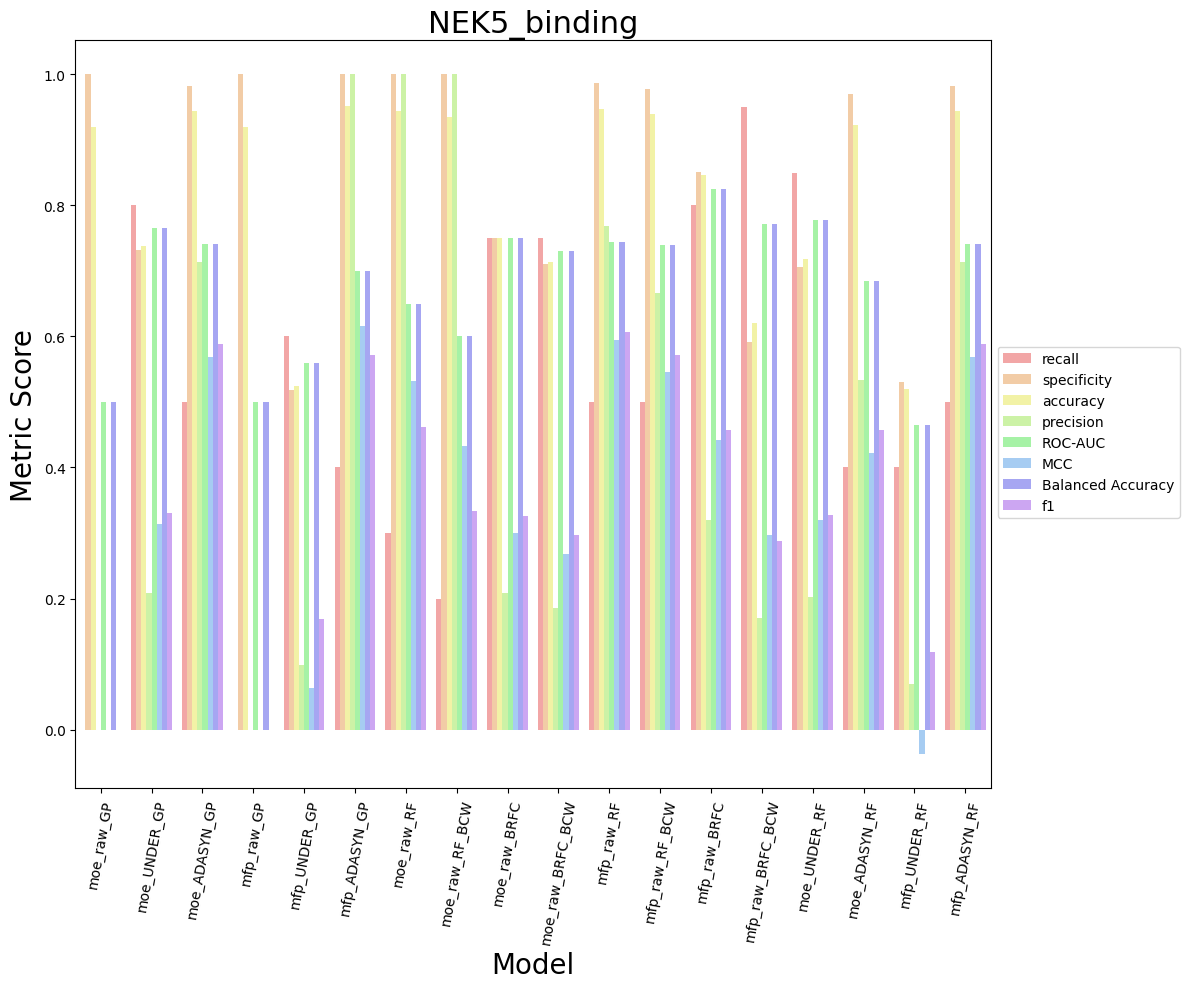

NEK9_binding


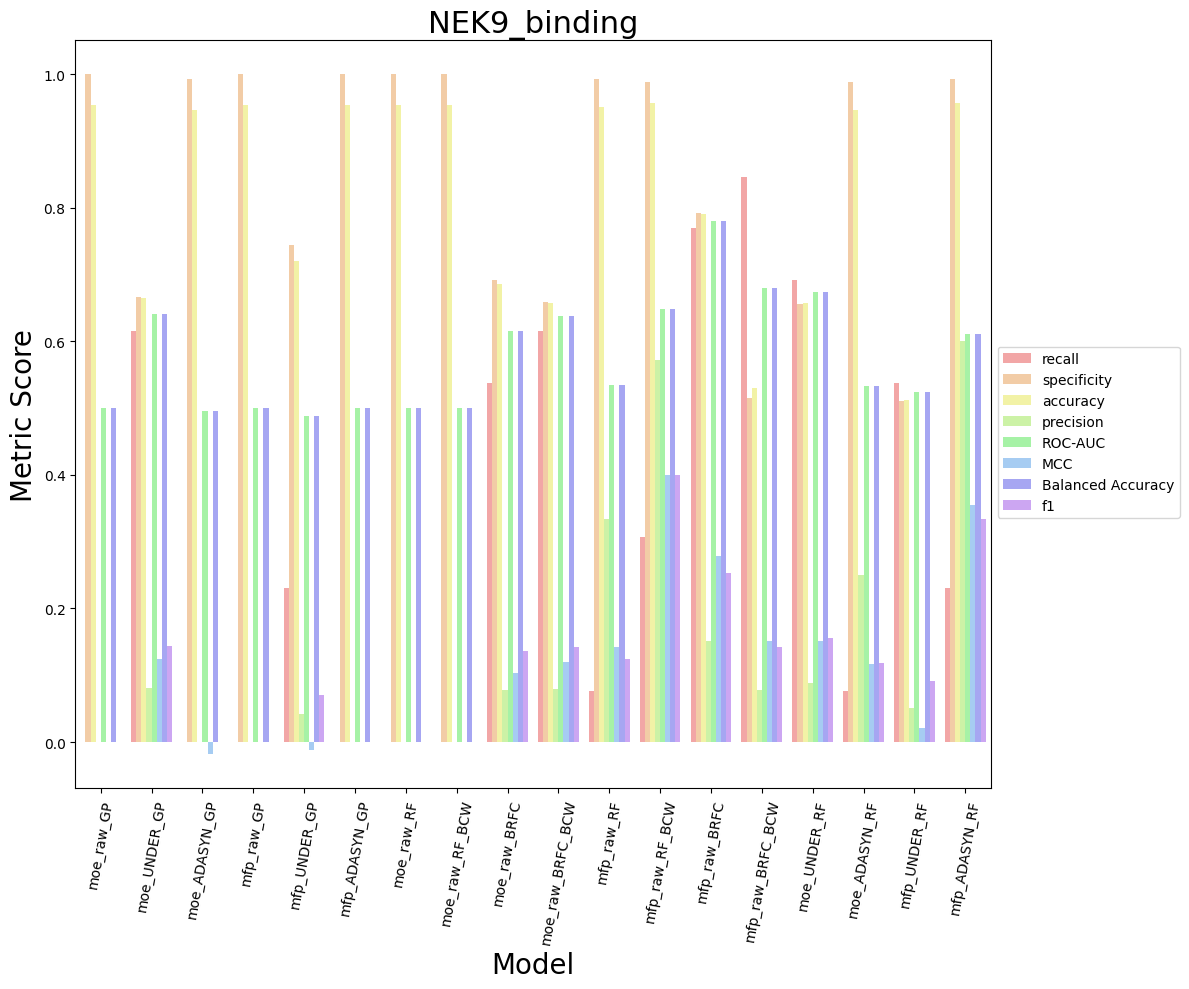

NEK2_inhibition


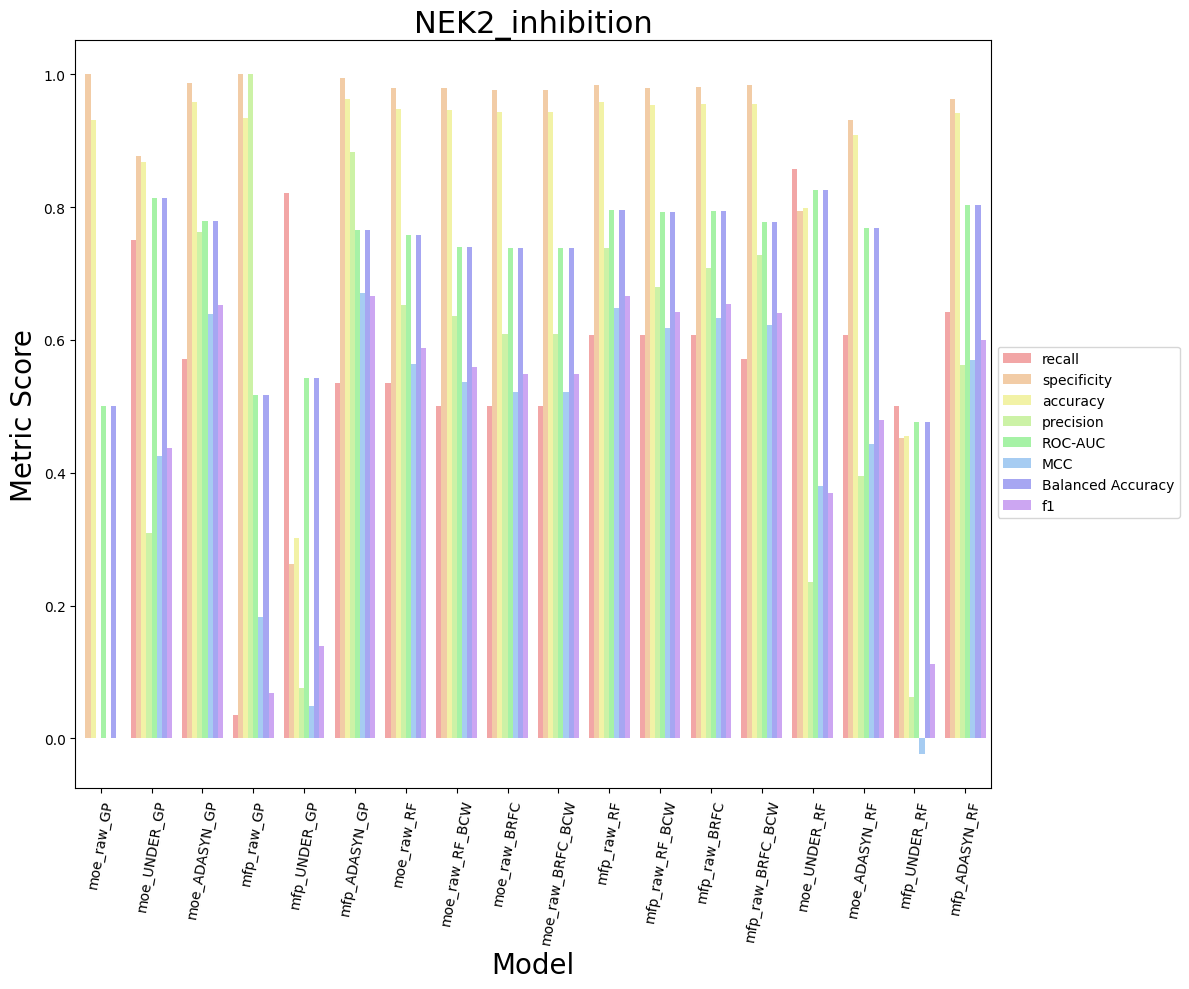

NEK9_inhibition


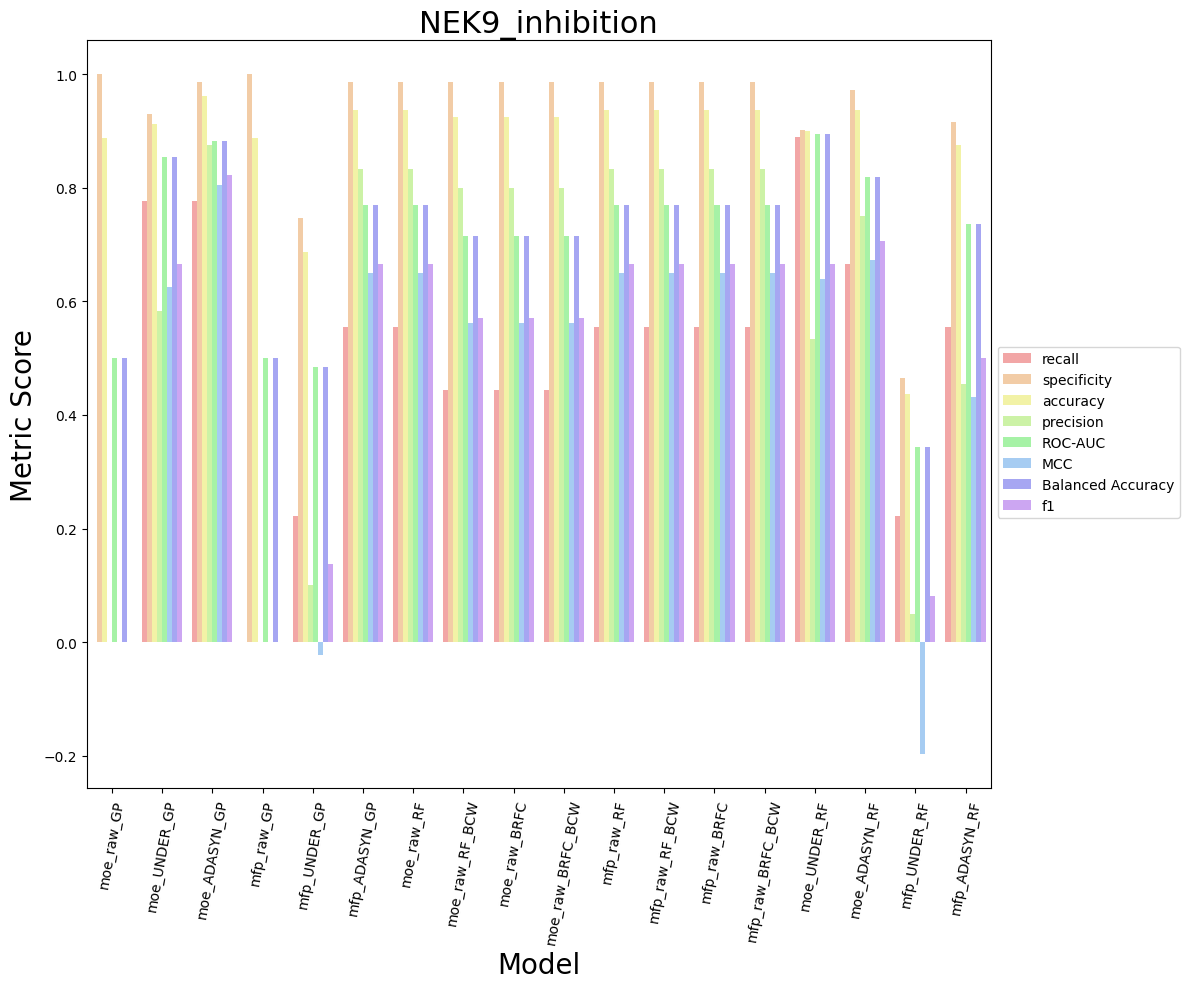

In [37]:
df=pd.concat([bind_df, inhib_df])

df['dataset_category'] = df['feat_type']+'_'+df['strategy']
# df['modeling_type'].unique()
df['model name'] = df['feat_type'].astype(str)+'_'+df['strategy']
df
metric_cols = ['recall', 'specificity', 'accuracy', 'precision',
             'ROC-AUC', 'MCC', 'Balanced Accuracy','f1', 'model name','NEK']
metric_palette2 = sns.color_palette('RdPu', n_colors=len(metric_cols) - 2) 
dflong = pd.melt(df, id_vars=['model name','NEK'], value_vars=['recall', 'specificity', 'accuracy', 'precision', 'ROC-AUC', 'MCC', 'Balanced Accuracy', 'f1'], 
                 var_name='Metric', value_name='Metric_value')
color_mapping = {
    'recall': '#FF9999',         # Light Red
    'specificity': '#FFCC99',    # Light Orange
    'accuracy': '#FFFF99',       # Light Yellow
    'precision': '#CCFF99',      # Light Green
    'ROC-AUC': '#99FF99',        # Light Light Green
    'MCC': '#99CCFF',            # Light Cyan
    'Balanced Accuracy': '#9999FF', # Light Blue
    'f1': '#CC99FF'              # Light Purple
}
for nek in dflong['NEK'].unique(): 
    this_df = dflong[dflong['NEK'] == nek]
    # this_df = this_df[metric_cols]
    
    print(nek)
    plt.figure(figsize=(12, 10)) 
    # ax=this_df.plot(x='model name',kind='bar', figsize=(10,10),width=1)
    ax = sns.barplot(data=this_df, x='model name', y='Metric_value', hue='Metric', palette=color_mapping)
    plt.xlabel('Model', fontsize=20)
    plt.ylabel('Metric Score', fontsize=20)
    plt.title(f'{nek}', fontsize=22)
    plt.xticks(rotation=80)  
    ax.legend(loc='upper left', bbox_to_anchor=(1,.6))
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(f'{nek}_all_metrics.png',bbox_inches='tight')
    plt.show();
    

In [157]:
df['dataset_category']


104       moe_raw
105     moe_UNDER
107    moe_ADASYN
108       mfp_raw
109     mfp_UNDER
          ...    
212    mfp_ADASYN
316     moe_UNDER
324    moe_ADASYN
332     mfp_UNDER
340    mfp_ADASYN
Name: dataset_category, Length: 108, dtype: object